In [394]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import skimage.transform as sktr

def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale)
    else:
        im2 = sktr.rescale(im2, 1./dscale)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2
def rescale(a):
    return np.interp(a, (a.min(), a.max()), (0, 1))
def compute_fft(a):
    fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(a))))
    return rescale(fft)

In [395]:
def read_img(img_name, img_dir = 'images_in/hybrid/', grayscale=False):
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    return img

def save_img(fname, img_out, out_dir = 'part2_out_dir/part2_2', grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [119]:
def create_gaussian_2d(sigma=3, ksize=19):
    gaussian_1d = cv2.getGaussianKernel(ksize, sigma)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    return gaussian_2d

def create_unit_impulse(filter_shape):
    unit_impulse = np.zeros((filter_shape))
    unit_impulse[unit_impulse.shape[0]//2, unit_impulse.shape[1]//2,] = 1
    return unit_impulse

def create_high_pass_filter(sigma=3, ksize=19):
    gaussian = create_gaussian_2d(sigma, ksize)
    unit_impulse = create_unit_impulse(gaussian.shape)
    return unit_impulse - gaussian

def convolve(filter, img):
    res = scipy.signal.convolve(img, filter, mode='same')
    res = np.clip(res, a_min=0, a_max=1)
    return res

def convolve_color(filter, img, color=True):
    res = np.zeros_like(img)
    if color:
        res[:,:,0] = convolve(filter, img[:,:,0])
        res[:,:,1] = convolve(filter, img[:,:,1])
        res[:,:,2] = convolve(filter, img[:,:,2])
    else:
        res = convolve(filter, img)
    return res

def opt_ksize(sigma):
    return 6*sigma+1

rgb_2_gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
def add_images(img1, img2):
    c1, c2 =  img1.shape[2] if len(img1.shape) > 2 else 0, img2.shape[2] if len(img2.shape) > 2 else 0
    combined = np.zeros_like(img1) if c1 > c2 else np.zeros_like(img2)
    if c1 > c2:
        for c in range(c1):
            combined[:,:,c] = img1[:,:,c] + img2
    elif c2 > c1:
        for c in range(c2):
            combined[:,:,c] = img2[:,:,c] + img1
    else:
        if c1 > 0:
            for c in range(c1):
                combined[:,:,c] = img2[:,:,c] + img1[:,:,c]
        else:
            combined = img2 + img1
    return combined

In [396]:
def hybrid_image(img1, img2, sigma1, sigma2, color1=True, color2=True):
    # img2, img1 = align_images(img2, img1)
    # save_img('aligned_'+'Derek', img1)
    # save_img('aligned_cat', img2)
    img1 = read_img('aligned_Derek.jpg', img_dir='part2_out_dir/part2_2')
    img2 = read_img('aligned_cat.jpg', img_dir='part2_out_dir/part2_2')
    # img1 = read_img('aligned_old.jpg', img_dir='part2_out_dir/part2_2')
    # img2 = read_img('aligned_new.jpg', img_dir='part2_out_dir/part2_2')
    # img1 = read_img('stern.jpg')
    # img2 = read_img('tongue.jpg')
    # img1 = read_img('aligned_'+'stern.jpg', img_dir='part2_out_dir/part2_2')
    # img2 = read_img('aligned_'+'happy.jpg', img_dir='part2_out_dir/part2_2')
    if not color1:
        img1 = rgb_2_gray(img1)
    if not color2:
        img2 = rgb_2_gray(img2)
        
    fft_inp_img1 = np.log(np.abs(np.fft.fftshift(np.fft.fft2(img1))))
    fft_inp_img2 = np.log(np.abs(np.fft.fftshift(np.fft.fft2(img2))))
    fft_inp_img1 = rescale(fft_inp_img1)
    fft_inp_img2 = rescale(fft_inp_img2)
    save_img('fft_inp_img1', fft_inp_img1, grayscale=True)
    save_img('fft_inp_img2', fft_inp_img2, grayscale=True)
    plt.imshow(fft_inp_img1)
    
    low_pass_filter = create_gaussian_2d(sigma1, opt_ksize(sigma1))

    img1_low = convolve_color(low_pass_filter, img1, color=color1)
    img2_high = img2 - convolve_color(create_gaussian_2d(sigma2, opt_ksize(sigma2)), img2, color=color2)

    fft_filtered_img1 = np.log(np.abs(np.fft.fftshift(np.fft.fft2(img1_low))))
    fft_filtered_img2 = np.log(np.abs(np.fft.fftshift(np.fft.fft2(img2_high))))
    fft_filtered_img1 = rescale(fft_filtered_img1)
    fft_filtered_img2 = rescale(fft_filtered_img2)
    save_img('fft_filtered_img1', fft_filtered_img1, grayscale=True)
    save_img('fft_filtered_img2', fft_filtered_img2, grayscale=True)

    combined = add_images(img1_low, img2_high)
    combined = np.clip(combined, a_min=0, a_max=1)
    return combined

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


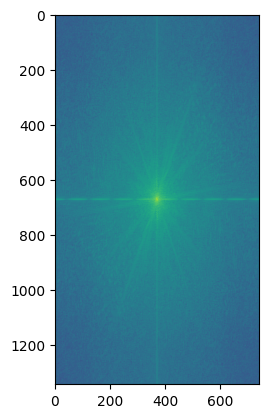

In [397]:
# im1 = read_img('DerekPicture.jpg')
# im2 = read_img('nutmeg.jpg')

sigma1 = 12
sigma2 = 6
hybrid = hybrid_image(im1, im2, sigma1, sigma2, color1=False, color2=False)
# plt.imshow(hybrid, )
save_img('fft_final', compute_fft(hybrid), grayscale=True)
# save_img('cat_color_'+'none' + '_hybird_'+str(sigma1)+'_'+str(sigma2), hybrid, grayscale=True)

In this example, I implemented the Bells and Whistles of using color. Below is an example of all 4 combinations of using color. Overall, using color in both the low frequency and high frequency images gave the best result. However, depending on the image chosen for the high frequencies, it is hard to notice the color from it, which can be seen in this example.